In [1]:
import matplotlib
matplotlib.use("Agg")
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from termcolor import colored
import scipy.io as sio
import io


import model_componets as comps
from data_loader import DataLoader
from commons import transform_util as tr_util
from model_componets import *
import vis_image as vis



Tensor("Const:0", shape=(3,), dtype=float32)
Tensor("Const_1:0", shape=(17, 3), dtype=float32)


In [2]:

data_loader = DataLoader()

train_batch_size, test_batch_size = 256, 256
lr_disc, lr_encoder, lr_decoder = 0.000002, 0.000002, 0.000002
disp_step_save, disp_step_valid = 1000, 500

num_batches_train = data_loader.get_num_batches('train',  train_batch_size)
num_batches_test = data_loader.get_num_batches('test',  test_batch_size)

os.environ['CUDA_VISIBLE_DEVICES'] = "1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

def get_network_params(scope):
    return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope)



In [3]:
input_pose = tf.placeholder(tf.float32, shape = [None,17,3], name='input_x')

x_real = input_pose #root relative 

x_view_norm_real, x_local_real = comps.root_relative_to_local(x_real)

encoder_real = EncoderNet(x_local_real) #local

z_real = encoder_real['z_joints']

decoder_real = DecoderNet(z_real)

x_local_recon = decoder_real['full_body_x']#local

x_recon = comps.local_to_root_relative(x_local_recon )#root relative


loss = tf.reduce_mean(tf.abs(x_real - x_recon))

param_encoder = get_network_params(scope='Encoder_net')
param_decoder = get_network_params(scope='Decoder_net')

#'./pretrained_weights/decoder_iter-894001'
#'./pretrained_weights/encoder_iter-894001'

#'./weights/AE_humans_mads_yt_mpi_l1/encoder_iter-460001'
#'./weights/AE_humans_mads_yt_mpi_l1/decoder_iter-460001'

#'../pose_embedding_training_full_norm_range_one_vneck/pretrained_weights/encoder_iter-993001'
#'../pose_embedding_training_full_norm_range_one_vneck/pretrained_weights/decoder_iter-993001'

# tf.train.Saver(param_encoder).restore(sess,'./weights/AE_humans_mads_yt_mpi_l1/encoder_iter-819001')
# tf.train.Saver(param_decoder).restore(sess,'./weights/AE_humans_mads_yt_mpi_l1/decoder_iter-819001')

tf.train.Saver(param_encoder).restore(sess,'./weights/AE_humans_mads_yt_mpi_l1/encoder_iter-1230001')
tf.train.Saver(param_decoder).restore(sess,'./weights/AE_humans_mads_yt_mpi_l1/decoder_iter-1230001')

W0423 19:17:25.430440 140571148334912 deprecation.py:506] From commons/tf_transform.py:17: calling norm (from tensorflow.python.ops.linalg_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
W0423 19:17:25.439090 140571148334912 deprecation_wrapper.py:119] From commons/tf_transform.py:91: The name tf.cross is deprecated. Please use tf.linalg.cross instead.

W0423 19:17:25.456513 140571148334912 deprecation.py:506] From commons/tf_transform.py:21: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
W0423 19:17:26.760742 140571148334912 deprecation_wrapper.py:119] From model_componets.py:207: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0423 19:17:26.762033 140571148334912 deprecation_wrapper.py:119

In [24]:

data_loader.shuffle_data('test')

batch_idx = 1
x_inputs = data_loader.get_test_data_batch(test_batch_size, batch_idx)
print(x_inputs.shape)
feed_dict  = {input_pose : x_inputs}
pose_loss,pose_recon = sess.run([loss,x_recon] , feed_dict = feed_dict)

(256, 17, 3)


In [25]:
print (pose_loss)

0.05626229


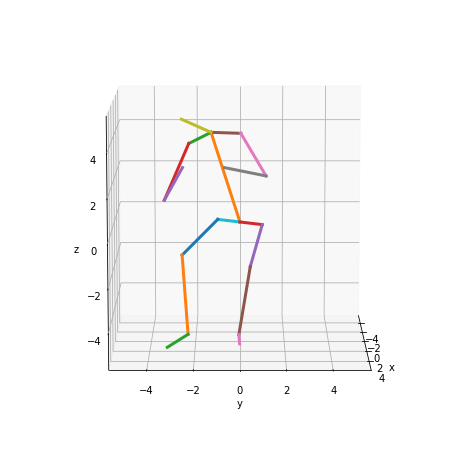

In [35]:
%matplotlib inline 
i = 130
fig = vis.get_figure()
ax = vis.get_ax(x_inputs[i],fig)
vis.plot_skeleton_and_scatter(x_inputs[i],ax)

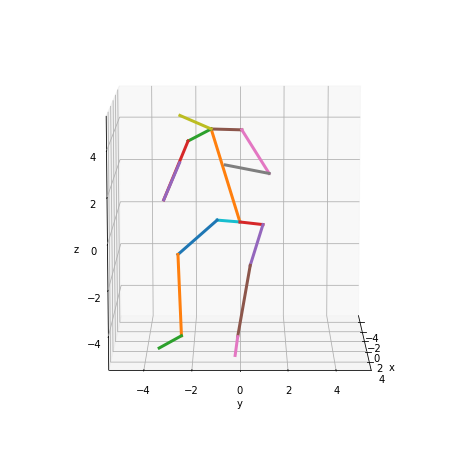

In [36]:
%matplotlib inline 
fig = vis.get_figure()
ax = vis.get_ax(pose_recon[i],fig)
vis.plot_skeleton_and_scatter(pose_recon[i],ax)

In [21]:
#produce pose from z

z_real = tf.placeholder(tf.float32, shape = [None,32], name = 'input_z')

decoder_real = DecoderNet(z_real)

x_local_recon = decoder_real['full_body_x']#local

x_recon2 = comps.local_to_root_relative(x_local_recon)#root relative

#x_recon2 = comps.local_to_view_norm(x_local_recon)

param_decoder = get_network_params(scope='Decoder_net')
tf.train.Saver(param_decoder).restore(sess,'./weights/AE_humans_mads_yt_mpi_l1/decoder_iter-1113001')

z_inputs = np.random.uniform(-1, 1, size=[256, 32])
feed_dict  = {z_real : z_inputs}
pose_recon = sess.run(x_recon2 , feed_dict = feed_dict)

In [22]:
pose_recon.shape

(256, 17, 3)

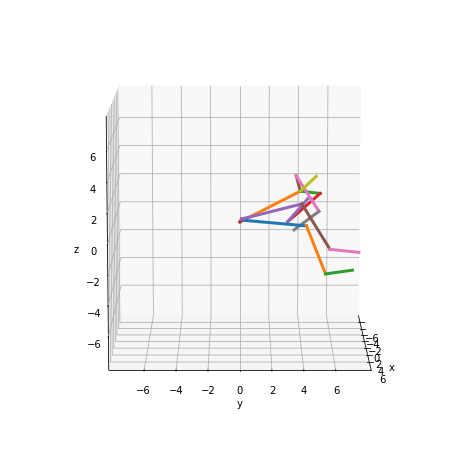

In [24]:
%matplotlib inline 
i = 64
fig = vis.get_figure()
ax = vis.get_ax(pose_recon[i],fig)
vis.plot_skeleton_and_scatter(pose_recon[i],ax)